# t2p3_runner.ipynb

A notebook to sequentially run different configurations of tests for the rga, rga_normal, and rga_21 rules.


In [20]:
%cd ../..  
# if the draculab folder is not in PYTHONPATH, we need to change the working directory
from draculab import *
import numpy as np

import matplotlib.pyplot as plt
import time

/home/z


In [2]:
# A function to create Haar matrices, used for connections from controllers to the plant
def haar_matrix(dim):
    """ Returns an array with the normalized (2**dim x 2**dim) Haar matrix.
    
        Args:
            dim: an integer.
        Returns:
            A 2D numpy array of shape (2**dim, 2**dim), where each row is a
            Haar vector of norm 1.
    """
    # Obtain the matrix using the iterative procedure with Kronecker products
    h0 = np.array([1., 1.])
    h1 = np.array([1., -1.])
    haar = np.concatenate(([h0], [h1]))
    for d in range(1,dim):
        haar = np.concatenate((np.kron(haar, h0), 
                               np.kron(np.identity(2**d), h1)), axis=0)
    # Normalize the rows of the Haar matrix
    for idx, row in enumerate(haar):
        haar[idx, :] = row / np.linalg.norm(row)
    return haar

In [3]:

def create_t2p3_net(params):
    """ Returns a network with the given configuration.
    
        Args:
            params: a parameter dictionary with these entries:
              N = size of each population (integer)
              t_pres = duration of each set of target values (float)
              M__P_type = type of the M to P connections. A string, either
                     'identity', 'haar', 'overcomplte', or 'overcomplete2'
              M_type = type of the units in the M population. A string, either
                  'am', am2D', 'am_pm', or 'am_pulse'.
              SPF__M_syn_type = type of the synapse from SPF to M (synapse)
              om_var = omega frequency heterogeneity (float)
              track_SPF__M_w = Boolean. Whether to track SPF__M weight for 1 M(E|I) unit
        Returns:
            net: a draculab network with the given configuration
            pops: a dictionary. Each entry has the name of a population, and
                  a list with the identifiers of units in that population.
            """
    N = params['N']
    t_pres = params['t_pres']
    M__P_type = params['M__P_type']
    M_type = params['M_type']
    SPF__M_syn_type = params['SPF__M_syn_type']
    om_var = params['om_var']
    track_SPF__M_w = params['track_SPF__M_w']
    #--------------------------------------------------------------
    M__P_mats = {'identity' : 1.*np.eye(N),
                 'haar' : haar_matrix(int(np.round(np.log(N)/np.log(2.)))),
                 'overcomplete2' : np.random.random((N, 3*N))}
    if N > 1:
        M__P_mats['overcomplete'] = np.concatenate((M__P_mats['identity'], M__P_mats['haar']), axis=1)
    norms = np.linalg.norm(M__P_mats['overcomplete2'], axis=0)
    M__P_mats['overcomplete2'] = M__P_mats['overcomplete2']/norms
    W = M__P_mats[M__P_type]
    M_N = W.shape[1]


    des_pat = np.zeros(N) # desired pattern in SP
    des_pats = np.random.random((2000, N)) # many desired patterns for SP
    des_pat[np.arange(0,N,2)] = .9 # a 'one' every other entry
    par_heter = 0.1 # range of heterogeneity as a fraction of the original value
    randz = lambda : (1. + par_heter*(np.random.rand(N)-0.5))

    net_params = {'min_delay' : 0.002,
                  'min_buff_size' : 10 }
    SF_params = {'type' : unit_types.sigmoidal,
                 'thresh' : 0. * randz(),
                 'slope' : 1. * randz(),
                 'init_val' : 0.2 * randz(),
                 'tau' : 0.05 }#* randz() }
    SP_params = {'type' : unit_types.source,
                 'init_val' : 0.5,
                 'function' : lambda x: None }
    SPF1_params = {'type' : unit_types.out_norm_sig,
                  'thresh' : 0.4 * randz(), # 0.5 originally
                  'slope' : 4. * randz(),  # 4. originally
                  'delay' : 0.3,
                  'init_val' : 0.3 * randz(),
                  'tau_fast': 0.01, # 0.005
                  'tau_mid': 0.2,  # 0.05
                  'tau_slow' : 10., # 5
                  'tau' : 0.05, #* randz(),
                  'des_out_w_abs_sum' : 1. }
    SPF2_params = SPF1_params
    P_params = {'type' : unit_types.linear,
                'init_val' : 0.,
                'tau' : 0.05 }#* randz() }

    if M_type == "am_pm":
        init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
        M_syn_type = unit_types.am_pm_oscillator
    elif M_type == "am2D":
        init_base = np.array([0.5, 0.5])
        M_syn_type = unit_types.am_oscillator2D
    elif M_type == "am_pulse":
        init_base = np.array([0.5, 0.5])
        M_syn_type = unit_types.am_pulse
    elif M_type == "am":
        init_base = np.array([0.5, 0.5, 0.5])
        M_syn_type = unit_types.am_oscillator
    M_params = {'type' : M_syn_type,
                'integ_meth' : 'odeint',
                'tau_u' : 0.1,
                'tau_c' : .1, # originally 0.2
                'init_val' : [(r+1.)*init_base for r in 0.2*(np.random.random(M_N)-0.5)],
                'multidim' : True,
                'n_ports' : 3,
                'omega' : 2.*np.pi,
                'custom_inp_del' : 200,
                'tau_fast': 0.005,
                'tau_mid' : 0.05,
                'tau_slow' : 1.,
                'delay' : 0.24,
                'A' : 1.,
                'mu' : 0.,
                'sigma' : 0.0 }

    def create_freqs_steps(n, w, r):
        """ Returns a 2-tuple with the lists required for heterogeneous frequencies.

            Args:
                n : number of units
                w : base angular (rad/s)
                r : amplitude of noise
            Returns
                2-tuple : (freqs, steps)
                freqs : a list with n angular frequencies.
                steps : a list with the corresponding delays. 
        """
        ws = w + r*(np.random.random(n) - 0.5)
        #ws = ws / M_params['tau_t'] # angular frequencies
        mp_del = np.arctan(P_params['tau']*ws)/ws
        psf_del = np.arctan(SF_params['tau']*ws)/ws
        sfspf_del = np.arctan(SPF1_params['tau']*ws)/ws
        spfm_del1 = np.arctan(M_params['tau_c']*ws)/ws
        spfm_del2 = np.arctan(M_params['tau_u']*ws)/ws
        d1 = mp_del + psf_del + sfspf_del + 4.*0.02
        del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
        return (list(ws), del_steps)

    om_var = 2. # increases omega frequency heterogeneity

    # creating units
    net = network(net_params)
    SF = net.create(N, SF_params)
    SP = net.create(N, SP_params)
    SPF1 = net.create(N, SPF1_params)
    SPF2 = net.create(N, SPF2_params)
    P = net.create(N, P_params)

    omegasE, del_stepsE = create_freqs_steps(M_N, M_params['omega'], om_var)
    M_params['omega'] = omegasE
    M_params['custom_inp_del'] = del_stepsE
    ME = net.create(M_N, M_params)

    omegasI, del_stepsI = create_freqs_steps(M_N, M_params['omega'], om_var)
    M_params['omega'] = omegasI
    M_params['custom_inp_del'] = del_stepsI
    MI = net.create(M_N, M_params)
    
    pops = {'SF':SF, 'SP':SP, 'SPF1':SPF1, 'SPF2':SPF2, 'P':P, 'ME':ME, 'MI':MI}

    # set the pattern in SP
    def make_fun(idx):
        #return lambda t: des_pat[idx]
        return lambda t: des_pats[int(round(t/t_pres)),idx]
    for idx, u in enumerate(SP):
        net.units[u].set_function(make_fun(idx))

    # Create the connections. See note on "detecting layer distances" in cortex wiki
    SF__SPF1_conn = {'rule' : "one_to_one",
                     'delay' : 0.02 }
    SF__SPF2_conn = SF__SPF1_conn
    SF__SPF1_syn = {'type' : synapse_types.static,
                   'init_w' : -1. }
    SF__SPF2_syn = {'type' : synapse_types.static,
                   'init_w' : 1. }
    SP__SPF1_conn = {'rule' : "one_to_one",
                    'delay' : 0.02 }
    SP__SPF2_conn = SP__SPF1_conn
    SP__SPF1_syn = {'type' : synapse_types.static,
                   'init_w' : 1. }
    SP__SPF2_syn = {'type' : synapse_types.static,
                   'init_w' : -1. }
    SPF1__ME_conn = {'rule': 'all_to_all',
                    'delay': 0.02 }
    SPF2__ME_conn = SPF1__ME_conn
    SPF1__MI_conn = SPF1__ME_conn
    SPF2__MI_conn = SPF1__ME_conn
    SPF1__ME_syn = {'type' : SPF__M_syn_type,
                    'lrate': 40.,
                    #'post_delay': del_steps,
                    'inp_ports': 0,
                    'max_w' : 2.,
                    'min_w' : 0.,
                    'sig1' : .2,
                    'sig2' : .2,
                    'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
    SPF2__ME_syn = SPF1__ME_syn
    SPF1__MI_syn = SPF1__ME_syn
    SPF2__MI_syn = SPF1__ME_syn

    # Specify the connection matrix from ME/MI to P
    #W = 2.*np.eye(N)
    #W = haar_matrix(3) # only for N = 2**dim

    # connect ME/MI to P
    ME__P_conn = {'rule': 'all_to_all',
                  'delay': 0.02 }
    ME__P_syn = {'type': synapse_types.static_l0_normal,
                 'w_sum' : 2.,
                 'tau_norml' : 5.,
                 'init_w' : W.flatten() }
    MI__P_conn = ME__P_conn
    MI__P_syn = {'type': synapse_types.static_l0_normal,
                 'w_sum' : 2.,
                 'tau_norml' : 5.,
                 'init_w' : -W.flatten() }
    # From P to SF
    P__SF_conn = {'rule' : 'one_to_one',
                  'delay' : 0.02 }
    P__SF_syn = {'type' : synapse_types.static,
                 'init_w' : 3. }
    # lateral connections in M
    ME__ME_conn = {'rule': 'all_to_all',
                   'allow_autapses' : False,
                   'delay' : 0.02 }
    ME__ME_syn = {'type' : synapse_types.static,
                  'lrate' : 0.1,
                  'inp_ports': 1,
                  'init_w' : -0.02/N }
    ME__MI_conn = {'rule': 'one_to_one',
                   'delay' : 0.02 }
    ME__MI_syn = {'type' : synapse_types.static,
                  'inp_ports': 1,
                  'init_w' : -0.5 } # -0.5 }
    MI__ME_conn = ME__MI_conn
    MI__ME_syn = ME__MI_syn
    MI__MI_conn = ME__ME_conn
    MI__MI_syn = ME__ME_syn

    net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
    net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
    net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
    net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
    net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
    net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
    net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
    net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
    net.connect(ME, P, ME__P_conn, ME__P_syn)
    net.connect(MI, P, MI__P_conn, MI__P_syn)
    net.connect(P, SF, P__SF_conn, P__SF_syn)
    net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
    net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
    net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
    net.connect(MI, ME, MI__ME_conn, MI__ME_syn)

    # tracking state variables of the am_pm_oscillator
    track_params = {'type' : unit_types.source,
                    'init_val' : 0.02,
                    'function' : lambda t: None }
    def create_state_track(uid, var_id):
        return lambda t: net.units[uid].buffer[var_id,-1]
    if M_type == "am":
        n_track = 3
    elif M_type in ["am2D", "am_pulse"]:
        n_track = 2
    elif M_type == "am_pm":
        n_track = 4
    M_track = net.create(n_track, track_params)
    for var in range(n_track):
        net.units[M_track[var]].set_function(create_state_track(ME[0],var))
    pops['M_track'] = M_track
    
    if track_SPF__M_w:
        # tracking SPF__ME weights
        SPF__M_track = net.create(2*N, track_params)
        SPF__M_syns = [syn for syn in net.syns[ME[0]] if syn.port == SPF1__ME_syn['inp_ports']]
        def SPF__M_fun(idx):
            """ Creates a function to track a weight from SPF to ME. """
            return lambda t: SPF__M_syns[idx].w
        for idx in range(len(SPF1+SPF2)):
            net.units[SPF__M_track[idx]].set_function(SPF__M_fun(idx))
        pops['SPF__M_track'] = SPF__M_track
        
    return net, pops

In [4]:
############################
#  Run all configurations  #
############################
sim_time = 100
N_l = [1, 2, 4, 8]
M__P_type_l = ['identity', 'haar', 'overcomplete', 'overcomplete2']
SPF__M_syn_type_l = [synapse_types.rga, synapse_types.rga_21] # rga, normal_rga, rga_21

M_type = "am2D"
t_pres = 10.
om_var = 1.
track_SPF__M_w = True # whether to track SPF__M weight for 1 M(E|I) unit

results = []

for N in N_l:
    for SPF__M_syn_type in SPF__M_syn_type_l:
        for M__P_type in M__P_type_l:
            if N==1 and (M__P_type == 'haar' or M__P_type == 'overcomplete'):
                break
            params = {'N' : N,
                      't_pres' : t_pres,
                      'om_var' : om_var,
                      'track_SPF__M_w' : track_SPF__M_w,
                      'M__P_type' : M__P_type,
                      'SPF__M_syn_type' : SPF__M_syn_type,
                      'M_type' : M_type }
            net, pops = create_t2p3_net(params)
            start_time = time.time()
            times, data, _  = net.flat_run(sim_time)
            print(params)
            print('Execution time is %s seconds' % (time.time() - start_time))
            data = np.array(data)
            results.append((params, pops, times, data))

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


{'track_SPF__M_w': True, 'M__P_type': 'identity', 'M_type': 'am2D', 'N': 1, 'SPF__M_syn_type': <synapse_types.rga: 203>, 't_pres': 10.0, 'om_var': 1.0}
Execution time is 24.877736568450928 seconds
{'track_SPF__M_w': True, 'M__P_type': 'identity', 'M_type': 'am2D', 'N': 1, 'SPF__M_syn_type': <synapse_types.rga_21: 220>, 't_pres': 10.0, 'om_var': 1.0}
Execution time is 26.168795824050903 seconds
{'track_SPF__M_w': True, 'M__P_type': 'identity', 'M_type': 'am2D', 'N': 2, 'SPF__M_syn_type': <synapse_types.rga: 203>, 't_pres': 10.0, 'om_var': 1.0}
Execution time is 49.16469073295593 seconds
{'track_SPF__M_w': True, 'M__P_type': 'haar', 'M_type': 'am2D', 'N': 2, 'SPF__M_syn_type': <synapse_types.rga: 203>, 't_pres': 10.0, 'om_var': 1.0}
Execution time is 50.99103283882141 seconds
{'track_SPF__M_w': True, 'M__P_type': 'overcomplete', 'M_type': 'am2D', 'N': 2, 'SPF__M_syn_type': <synapse_types.rga: 203>, 't_pres': 10.0, 'om_var': 1.0}
Execution time is 78.14523386955261 seconds
{'track_SPF__M_

In [8]:
# load results
import pickle
#fname = 't2p3_results_2020-06-02_15:52'
#fname = 't2p3_results_2020-06-02_15:58'
fname = 't2p4_results_2020-06-02_16:49'
with (open(fname, "rb")) as f:
    results = pickle.load(f)
    f.close()

N_used = set()
M__P_type_l = set()
for conf, pops, times, data in results:
    N_used.add(conf['N'])
    M__P_type_l.add(conf['M__P_type'])
N_l = N_used

In [9]:
# Create a matrix of results for each of the learning rules
# The measure we will use will be the mean value of the norm of SP-SF 
# (both vectors normalized) for the last half of the simulation

# rows will be number of units, columns the M__P connection type
rga_res = np.zeros((len(N_l), len(M__P_type_l)))
rga_21_res = np.zeros((len(N_l), len(M__P_type_l)))
rga_ge_res = np.zeros((len(N_l), len(M__P_type_l)))
static_res = np.zeros((len(N_l), len(M__P_type_l)))

ct2idx = {'identity' : 0,
          'haar': 1,
          'overcomplete' : 2,
          'overcomplete2': 3 }
N2idx = [None, 0, 1, None, 2, None, None, None, 3]

for conf, pops, times, data in results:
    init_idx = int(np.round(len(times)/2.))
    SP_data = np.array(data[pops['SP']])
    SF_data = np.array(data[pops['SF']])
    if conf['N'] > 1:
        SP_data_unit = (SP_data/np.linalg.norm(SP_data, axis=0))
        SF_data_unit = (SF_data/np.linalg.norm(SF_data, axis=0))
        SP_SF = SP_data_unit - SF_data_unit
    else:
        SP_SF = SP_data - SF_data
    SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
    mean_error = np.mean(SP_SF_norm[init_idx:])
    if conf['SPF__M_syn_type'] == synapse_types.rga:
        rga_res[N2idx[conf['N']]][ct2idx[conf['M__P_type']]] = mean_error
    elif conf['SPF__M_syn_type'] == synapse_types.rga_21:
        rga_21_res[N2idx[conf['N']]][ct2idx[conf['M__P_type']]] = mean_error
    elif conf['SPF__M_syn_type'] == synapse_types.rga_ge:
        rga_ge_res[N2idx[conf['N']]][ct2idx[conf['M__P_type']]] = mean_error
    elif conf['SPF__M_syn_type'] == synapse_types.static:
        static_res[N2idx[conf['N']]][ct2idx[conf['M__P_type']]] = mean_error

In [29]:
# save the error matrices
import pickle
mat = 'rga_ge'
mat_dict = {'rga' : rga_res,
            'rga_21' : rga_21_res,
            'rga_ge' : rga_ge_res,
            'static' : static_res }
fname = time.strftime('t2p3_static_mat_'+mat+'_%Y-%m-%d_%H:%M', time.localtime())
with open(fname, 'wb') as f:
    pickle.dump(results, f)
    f.close()

In [ ]:
# load an error matrix
fname = 't2p3_mat_rga_2020-06-02_x:x'
with (open(fname, "rb")) as f:
    mat_dict = pickle.load(f)
    f.close()

In [17]:
static_res = 0.5*(np.array([[0.22769621, 0.,         0.,         0.        ],
 [0.31305371, 0.46342887, 0.17132054, 0.30255647],
 [0.58232391, 0.59998432, 0.46372432, 0.31910008],
 [0.71874512, 0.55159493, 0.56727825, 0.46462203]]) + 
                 np.array([[0.42190227, 0.,         0.,         0.,        ],
 [0.39447633, 0.53267049, 0.30840609, 0.35248648],
 [0.68585871, 0.50405074, 0.50539018, 0.45661101],
 [0.66791114, 0.62272995, 0.52351982, 0.4782997 ]]))
static_res

array([[0.32479924, 0.        , 0.        , 0.        ],
       [0.35376502, 0.49804968, 0.23986332, 0.32752148],
       [0.63409131, 0.55201753, 0.48455725, 0.38785554],
       [0.69332813, 0.58716244, 0.54539903, 0.47146087]])

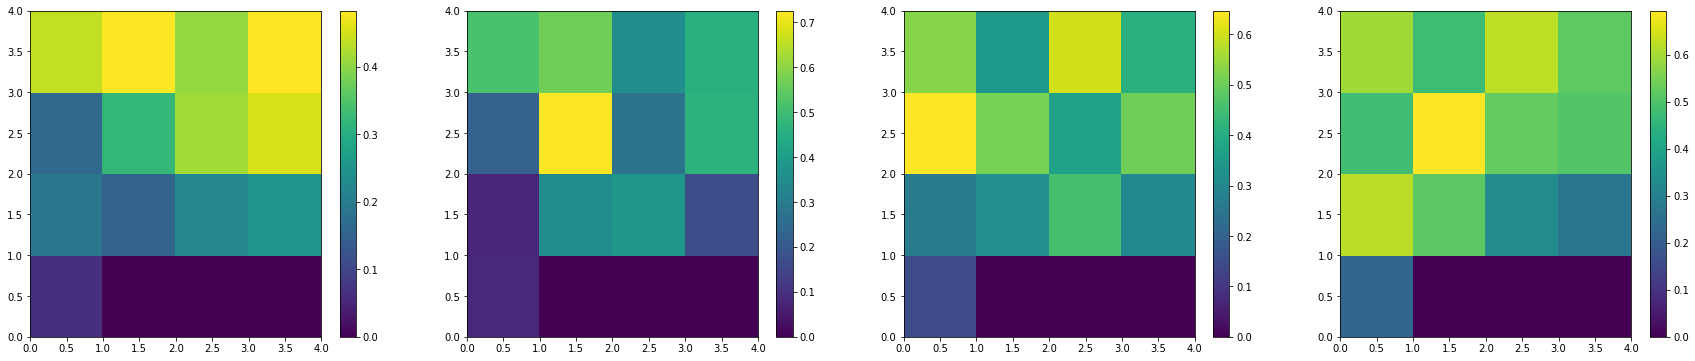

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(30,6))
#cm = ['RdBu_r'] 
cm = ['viridis']
for col in range(4):
    for row in range(1):
        ax = axs[col]
        if col == 0:
            pcm = ax.pcolormesh(rga_res, cmap=cm[row])
        elif col == 1:
            pcm = ax.pcolormesh(rga_21_res, cmap=cm[row])
        elif col == 2:
            pcm = ax.pcolormesh(rga_ge_res, cmap=cm[row])
        else:
            pcm = ax.pcolormesh(static_res, cmap=cm[row])
        fig.colorbar(pcm, ax=ax)
plt.show()

In [13]:
# See which matrices you currently have
print('rga = ', end=' ')
print(rga_res)
print('rga_21 = ', end=' ')
print(rga_21_res)
print('rga_ge = ', end=' ')
print(rga_ge_res)
print('static = ', end=' ')
print(static_res)

rga =  [[0.0672763  0.         0.         0.        ]
 [0.19208212 0.15287264 0.22184759 0.25159534]
 [0.16238566 0.31957827 0.41541301 0.45550298]
 [0.43802692 0.48023204 0.40432845 0.48282284]]
rga_21 =  [[0.08081019 0.         0.         0.        ]
 [0.07413275 0.34782846 0.38308128 0.16832849]
 [0.22316039 0.7259277  0.2770722  0.46648245]
 [0.51685741 0.56524131 0.35454536 0.4616029 ]]
rga_ge =  [[0.1474573  0.         0.         0.        ]
 [0.27044351 0.32033088 0.45545521 0.30493695]
 [0.64735541 0.51426716 0.36693918 0.5056328 ]
 [0.53030016 0.34769271 0.60169025 0.41147424]]
static =  [[0.2234889  0.         0.         0.        ]
 [0.62230571 0.51774598 0.3300192  0.27268264]
 [0.48001096 0.69364726 0.52786994 0.50447326]
 [0.59523818 0.47556462 0.62434076 0.52236954]]


In [12]:
# Set matrices

# from t2p3_results_2020-06-02_15:58
rga_21_res = np.array([[0.08081019, 0.        , 0.        , 0.        ],
       [0.07413275, 0.34782846, 0.38308128, 0.16832849],
       [0.22316039, 0.7259277 , 0.2770722 , 0.46648245],
       [0.51685741, 0.56524131, 0.35454536, 0.4616029 ]])
# from t2p3_results_2020-06-02_15:52
rga_res = np.array([[0.0672763 , 0.        , 0.        , 0.        ],
       [0.19208212, 0.15287264, 0.22184759, 0.25159534],
       [0.16238566, 0.31957827, 0.41541301, 0.45550298],
       [0.43802692, 0.48023204, 0.40432845, 0.48282284]])
# from t2p4_results_2020-06-02_16:49
rga_ge_res = np.array([[0.1474573 , 0.        , 0.        , 0.        ],
       [0.27044351, 0.32033088, 0.45545521, 0.30493695],
       [0.64735541, 0.51426716, 0.36693918, 0.5056328 ],
       [0.53030016, 0.34769271, 0.60169025, 0.41147424]])
# from a t2p4_runner run with sim_time=200, t_pres=10
static_res = np.array([[0.2234889 , 0.        , 0.        , 0.        ],
       [0.62230571, 0.51774598, 0.3300192 , 0.27268264],
       [0.48001096, 0.69364726, 0.52786994, 0.50447326],
       [0.59523818, 0.47556462, 0.62434076, 0.52236954]])

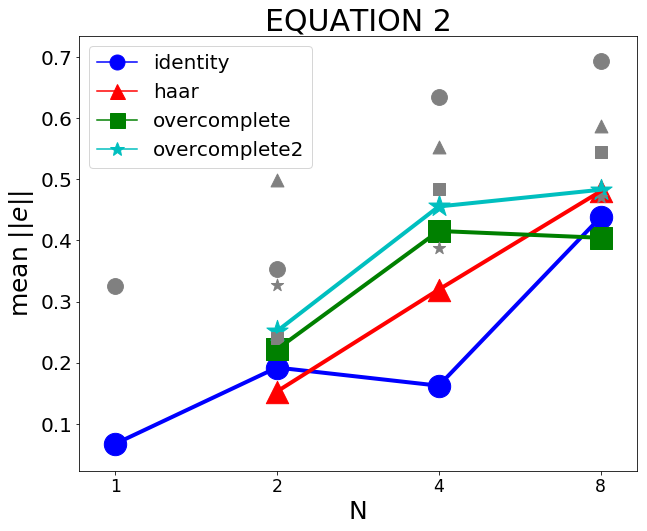

In [19]:
# PLOT SINGLE MATRIX
mat = 'rga'
mat_dict = {'rga' : rga_res,
            'rga_21' : rga_21_res,
            'rga_ge' : rga_ge_res,
            'static' : static_res }
title_dict = {'rga' : 'EQUATION 2',
            'rga_21' : 'EQUATION 3',
            'rga_ge' : 'EQUATION 4',
            'static' : 'CONTROL' }
fig = plt.figure(figsize=(10,8))
res = mat_dict[mat]
labels = ['' for _ in range(4)]
plt.xticks([1,2,3,4], ['1', '2', '4', '8'], fontsize='xx-large')
plt.yticks(fontsize=20)
plt.xlabel('N', fontsize=25)
plt.ylabel('mean $||e||$', fontsize=25)
plt.title(title_dict[mat], fontsize=30)

colors=['b', 'r', 'g', 'c']
for key in ct2idx:
    labels[ct2idx[key]] = key # so order is preserved
plt.plot(list(range(1,5)), res[:,0], linewidth=4, color=colors[0])
for idx, label in enumerate(labels[1:]):
    plt.plot(list(range(2,5)), res[1:,idx+1], linewidth=4, color=colors[idx+1])
#plt.legend(labels, fontsize='20')

import matplotlib.lines as mlines

markers = ['o', '^', 's', '*',]
ms = 500 # marker size
plt.scatter(list(range(1,5)), res[:,0], s=ms, c=colors[0])
for idx, label in enumerate(labels[1:]):
    plt.scatter(list(range(2,5)), res[1:,idx+1], s=ms, marker=markers[idx+1], c=colors[idx+1])

dot = mlines.Line2D([],[], marker='o', markersize=15, color=colors[0], label=labels[0])
tri = mlines.Line2D([],[], marker='^', markersize=15, color=colors[1], label=labels[1])
squ = mlines.Line2D([],[], marker='s', markersize=15, color=colors[2], label=labels[2])
sta = mlines.Line2D([],[], marker='*', markersize=15, color=colors[3], label=labels[3])
plt.legend(handles=[dot,tri,squ,sta], fontsize='20')

# plotting control data    
plt.scatter(list(range(1,5)), static_res[:,0], s=int(ms/2), c='gray')
for idx, label in enumerate(labels[1:]):
    plt.scatter(list(range(2,5)), static_res[1:,idx+1], s=int(ms/3), marker=markers[idx+1], c='gray')
    
plt.show()

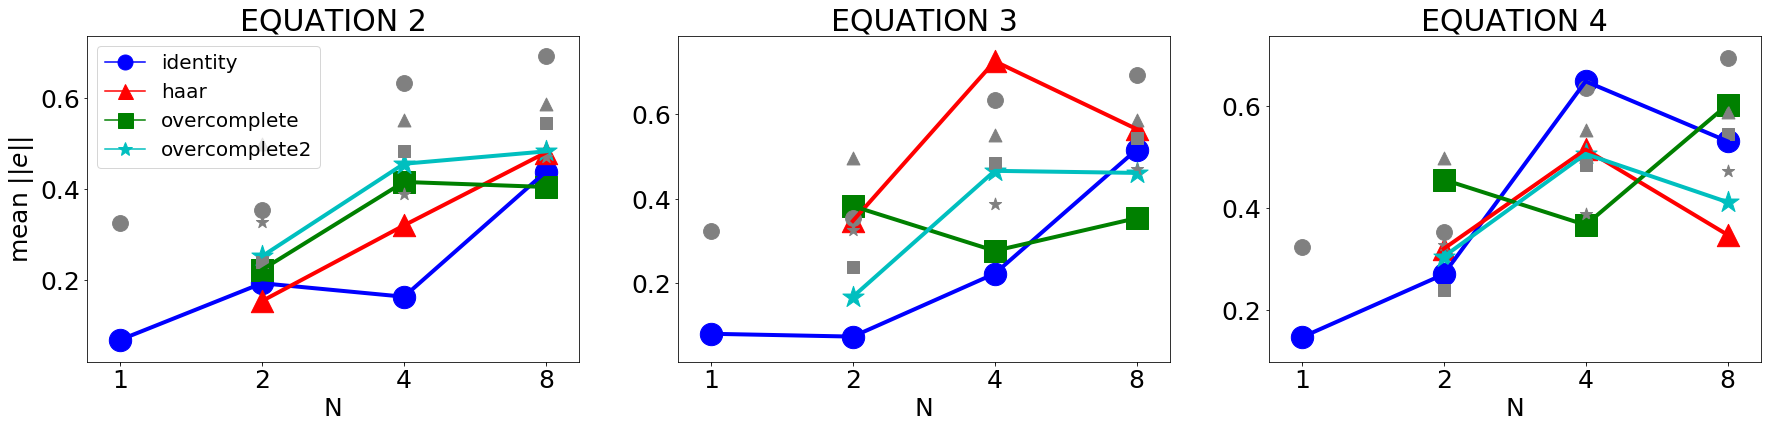

In [18]:
# PLOT ALL MATRICES
import matplotlib.lines as mlines

mat_dict = {'rga' : rga_res,
            'rga_21' : rga_21_res,
            'rga_ge' : rga_ge_res,
            'static' : static_res }
title_dict = {'rga' : 'EQUATION 2',
            'rga_21' : 'EQUATION 3',
            'rga_ge' : 'EQUATION 4',
            'static' : 'CONTROL' }

# plt.xticks([1,2,3,4], ['1', '2', '4', '8'], fontsize='xx-large')
# plt.yticks(fontsize=20)
# plt.xlabel('N', fontsize=25)
#plt.ylabel('mean $||e||$', fontsize=25)

fig, axs =  plt.subplots(1, 3, figsize=(30,6), sharey=False)
# colors, labels, markers, handles
colors=['b', 'r', 'g', 'c']
labels = ['' for _ in range(4)]
for key in ct2idx:
    labels[ct2idx[key]] = key # so order is preserved
dot = mlines.Line2D([],[], marker='o', markersize=15, color=colors[0], label=labels[0])
tri = mlines.Line2D([],[], marker='^', markersize=15, color=colors[1], label=labels[1])
squ = mlines.Line2D([],[], marker='s', markersize=15, color=colors[2], label=labels[2])
sta = mlines.Line2D([],[], marker='*', markersize=15, color=colors[3], label=labels[3])
hands = [dot,tri,squ,sta]
markers = ['o', '^', 's', '*',]
ms = 500 # marker size

#fig.title(title_dict[mat], fontsize=30)
plt.setp(axs, xticks=[1,2,3,4], xticklabels=['1', '2', '4', '8'])
axs[0].set_ylabel('mean $||e||$', fontsize=25)

for midx, mat in enumerate(['rga', 'rga_21', 'rga_ge']):
    res = mat_dict[mat]
    ax = axs[midx]
    # ticks, titles
    ax.tick_params(axis='both', labelsize=25)
    ax.set_xlabel('N', fontsize=25)
    ax.set_xticks([1,2,3,4], ['1', '2', '4', '8']) #, fontsize='xx-large')
    #ax.set_ylabel('mean $||e||$', fontsize=25)
    ax.set_title(title_dict[mat], fontsize=30)

    ax.plot(list(range(1,5)), res[:,0], linewidth=4, color=colors[0])
    for idx, label in enumerate(labels[1:]):
        ax.plot(list(range(2,5)), res[1:,idx+1], linewidth=4, color=colors[idx+1])
    #plt.legend(labels, fontsize='20')

    ax.scatter(list(range(1,5)), res[:,0], s=ms, c=colors[0])
    for idx, label in enumerate(labels[1:]):
        ax.scatter(list(range(2,5)), res[1:,idx+1], s=ms, marker=markers[idx+1], c=colors[idx+1])

    if midx==0:
        ax.legend(handles=[dot,tri,squ,sta], fontsize='20')

    # plotting control data    
    ax.scatter(list(range(1,5)), static_res[:,0], s=int(ms/2), c='gray')
    for idx, label in enumerate(labels[1:]):
        ax.scatter(list(range(2,5)), static_res[1:,idx+1], s=int(ms/3), marker=markers[idx+1], c='gray')
    
plt.show()
    

In [8]:
print('rga = ', end=' ')
print(rga_res)
print('rga_21 = ', end=' ')
print(rga_21_res)
print('rga_ge = ', end=' ')
print(rga_ge_res)

rga =  [[0.10285041 0.         0.         0.        ]
 [0.2685118  0.17117608 0.15205515 0.27618877]
 [0.33357044 0.31369711 0.36998261 0.71005078]
 [1.08093056 1.09397715 0.84265837 0.86116448]]
rga_21 =  [[0.06050534 0.         0.         0.        ]
 [0.45623933 0.20435906 0.40780659 0.173905  ]
 [0.55320819 0.78923316 0.50570689 0.47200822]
 [1.08409747 0.97923379 0.98734717 1.02752419]]
rga_ge =  [[0.13977255 0.         0.         0.        ]
 [0.47017117 0.31192385 0.27634928 0.21541184]
 [0.35528827 0.6776158  0.69896492 0.64416085]
 [1.03342352 0.77277187 0.73615685 0.83248514]]


In [14]:
labels = ['' for _ in range(4)]
for key in ct2idx:
    labels[ct2idx[key]] = key
labels

['identity', 'haar', 'overcomplete', 'overcomplete2']

In [18]:
# choose a particular result
conf, pops, times, data = results[1]
for name in pops:
    exec(name + '=' + str(pops[name]))
print(conf)

{'track_SPF__M_w': True, 'SPF__M_syn_type': <synapse_types.rga_21: 220>, 'N': 1, 'M_type': 'am2D', 't_pres': 10.0, 'M__P_type': 'identity', 'om_var': 1.0}


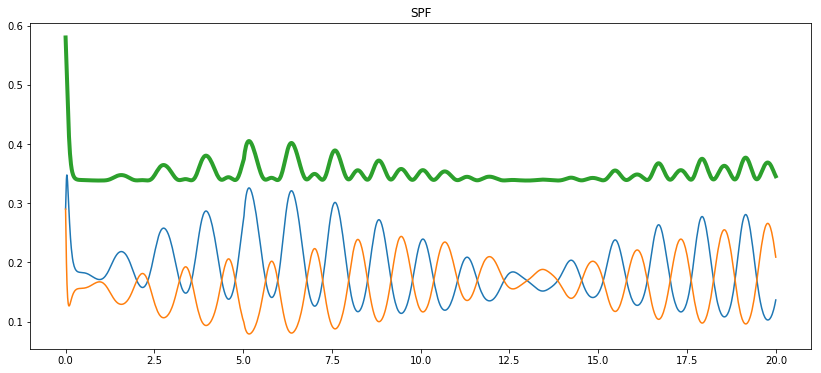

[0.13665077 0.20902266]


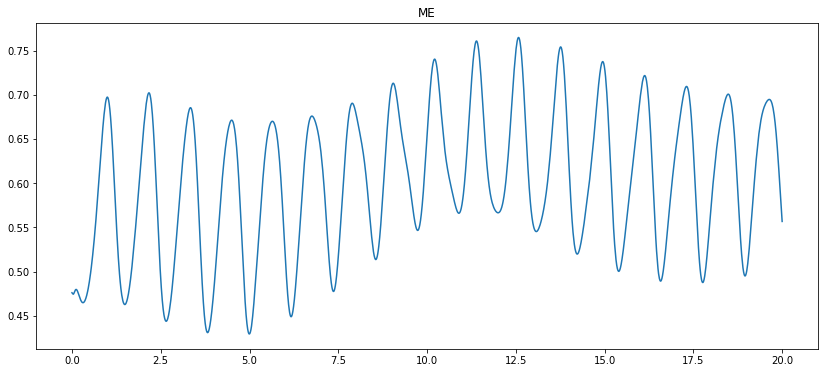

[0.55666895]


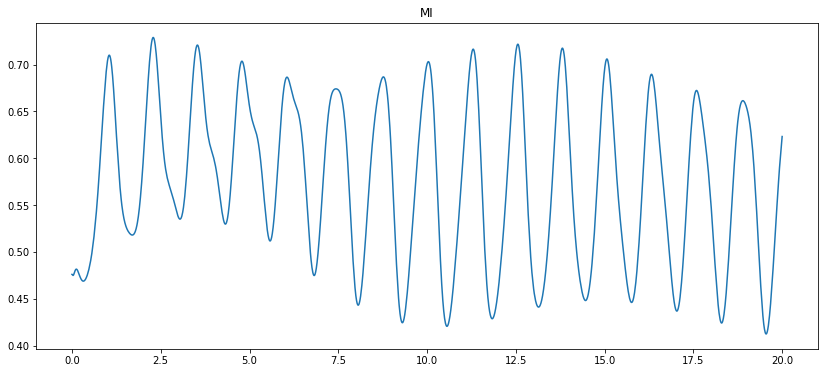

[0.62312714]


In [19]:
fs = (14,6)
# SPF
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.plot(times, np.sum(SPF_data, axis=0), linewidth=4)
plt.title('SPF')
plt.show()
print(SPF_data[:,-1])

# M
ME_fig = plt.figure(figsize=fs)
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.title('ME')
plt.show()
print(ME_data[:,-1])

MI_fig = plt.figure(figsize=fs)
MI_data = np.array(data[MI])
plt.plot(times, MI_data.transpose())
plt.title('MI')
plt.show()
print(MI_data[:,-1])


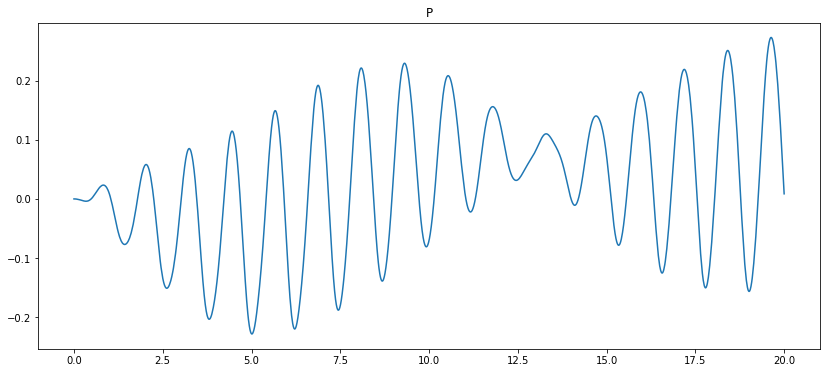

[0.00862579]


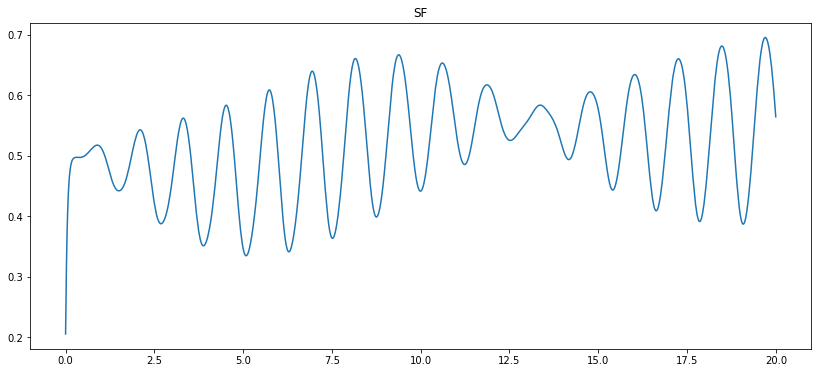

[0.5642045]
[0.55079984]


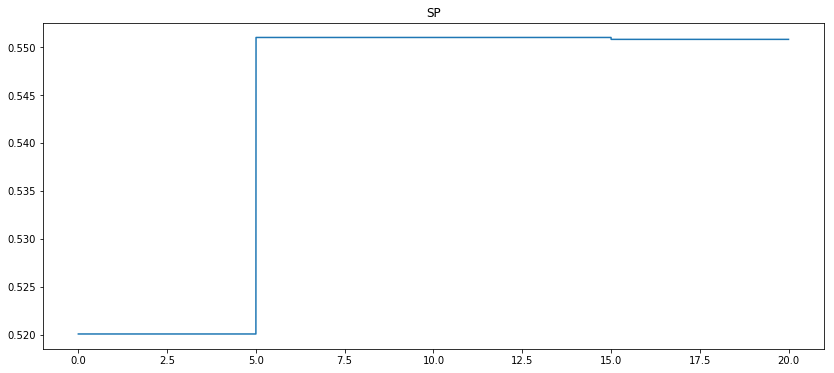

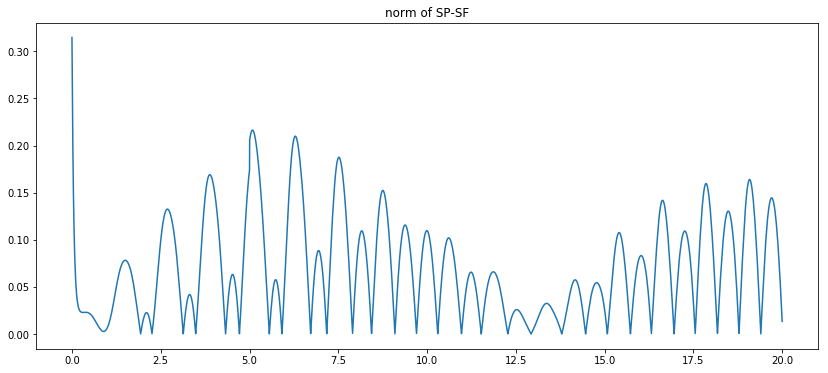

In [20]:
fs = (14,6)
# P
P_fig = plt.figure(figsize=fs)
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.title('SF')
plt.show()
print(SF_data[:,-1])

# SP
SP_fig = plt.figure(figsize=fs)
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.title('SP')
print(SP_data[:,-1])

# SP-SF
SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
SP_SF_fig = plt.figure(figsize=fs)
plt.plot(times, SP_SF_norm)
plt.title('norm of SP-SF')
plt.show()


In [21]:
[net.syns[ME[0]][i].idm_id for i in [0,1, 2, 3]]

AttributeError: 'static_synapse' object has no attribute 'idm_id'

In [22]:
# state var trackers
M_track_fig = plt.figure(figsize=fs)
track_data = np.array(data[M_track])
plt.plot(times, data[M_track[0]])
plt.plot(times, data[M_track[1]])
if M_type == "am":
    plt.plot(times, data[M_track[2]])
elif M_type == "am_pm":
    plt.plot(times, data[M_track[3]])
if M_type == "am2D":
    plt.legend(['u','c'])
else:
    plt.legend(['u','c','I'])
#plt.plot(times, track_data.trose())
#plt.plot(times, data[ME[0],:],'r')
plt.title(' state vars sample')

# weight tracking
W_fig1 = plt.figure(figsize=fs)
w_track_data1 = np.array(data[SPF__M_track[0:N]])
w_track_data2 = np.array(data[SPF__M_track[N:]])
plt.plot(times, w_track_data1.transpose())
SPF__M_legends1 = ['SPF1['+str(i)+']--M' for i in range(N)]
plt.plot(times, w_track_data2.transpose())
SPF__M_legends2 = ['SPF2['+str(i)+']--M' for i in range(N)]
plt.legend(SPF__M_legends1+SPF__M_legends2)
plt.title('SPF--M weights')

# joint plot
joint_fig, axs = plt.subplots(2, 2, figsize=(2.2*fs[0], 2.2*fs[1]))
axs[0][0].plot(times, SPF_data.transpose(), linewidth=2)
axs[0][0].set_title('SPF')
P_data = np.array(data[P])
axs[0][1].plot(times, P_data.transpose())
axs[0][1].set_title('P')
axs[1][0].plot(times, ME_data.transpose())
axs[1][0].plot(times, MI_data.transpose())
axs[1][0].set_title('ME, MI')
axs[1][1].plot(times, SP_data.transpose())
axs[1][1].plot(times, SF_data.transpose())
axs[1][1].set_title('SP, SF')

plt.show()

ZeroDivisionError: integer division or modulo by zero

In [11]:
m_id = 0
for idx, syn in enumerate(net.syns[ME[m_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    elif pre_id in GE:
        pre_pop = 'GE'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME[%d], w=%f, port=%d'%(idx, pre_pop, pre_id, m_id, syn.w, syn.port))

0) SPF1 (4) --> ME[0], w=0.439826, port=0
1) SPF1 (5) --> ME[0], w=-0.031386, port=0
2) SPF2 (6) --> ME[0], w=-0.342711, port=0
3) SPF2 (7) --> ME[0], w=0.187489, port=0
4) ME (11) --> ME[0], w=-0.010000, port=1
5) MI (12) --> ME[0], w=-0.500000, port=1


In [12]:
m_id = 0
for idx, syn in enumerate(net.syns[MI[m_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    elif pre_id in GE:
        pre_pop = 'GE'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI[%d], w=%f, port=%d'%(idx, pre_pop, pre_id, m_id, syn.w, syn.port))

0) SPF1 (4) --> MI[0], w=-0.444318, port=0
1) SPF1 (5) --> MI[0], w=0.123013, port=0
2) SPF2 (6) --> MI[0], w=0.316357, port=0
3) SPF2 (7) --> MI[0], w=-0.117513, port=0
4) MI (13) --> MI[0], w=-0.010000, port=1
5) ME (10) --> MI[0], w=-0.500000, port=1
